In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
spark

In [ ]:
rdd = spark.read.csv('casestudy.csv', header=True, inferSchema=True)

In [ ]:
rdd.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- customer_email: string (nullable = true)
 |-- net_revenue: double (nullable = true)
 |-- year: integer (nullable = true)



In [ ]:
rdd.take(5)

[Row(_c0=0, customer_email=' nhknapwsbx@gmail.com', net_revenue=249.92, year=2015),
 Row(_c0=1, customer_email='joiuzbvcpn@gmail.com', net_revenue=87.61, year=2015),
 Row(_c0=2, customer_email='ukkjctepxt@gmail.com', net_revenue=168.38, year=2015),
 Row(_c0=3, customer_email=' gykatilzrt@gmail.com', net_revenue=62.4, year=2015),
 Row(_c0=4, customer_email='mmsgsrtxah@gmail.com', net_revenue=43.08, year=2015)]

In [ ]:
rdd.registerTempTable("orders")



---

•	Total revenue for the current year

In [ ]:
query = "SELECT year, sum(net_revenue) as total_revenue \
        FROM orders \
        GROUP BY year"
total_revenue_each_year = spark.sql(query)
total_revenue_each_year.take(10)

[Row(year=2015, total_revenue=29036749.18999953),
 Row(year=2016, total_revenue=25730943.589999683),
 Row(year=2017, total_revenue=31417495.02999995)]

Text(0.5, 1.0, 'total_revenue_each_year')

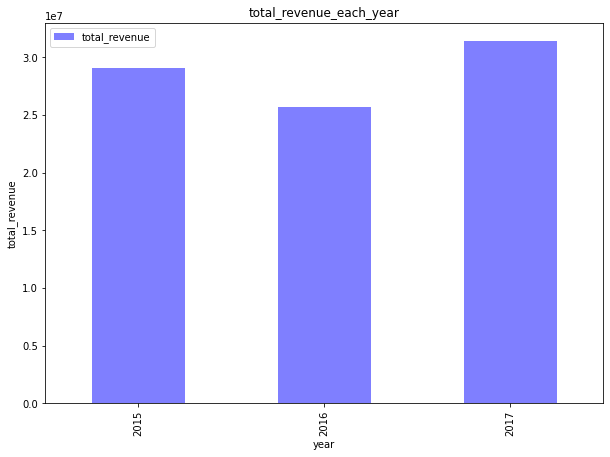

In [ ]:
total_revenue_each_year_pd = total_revenue_each_year.toPandas()
pl = total_revenue_each_year_pd.plot(kind="bar", 
                            x="year", y="total_revenue", 
                            figsize=(10, 7),  alpha=0.5, color="blue")
pl.set_xlabel("year")
pl.set_ylabel("total_revenue")
pl.set_title("Total Revenue Each Year")



---

•	New Customer Revenue e.g. new customers not present in previous year only

In [ ]:
query = 'select sum(net_revenue)\
        from (select customer_email, net_revenue from orders where year=2016 and customer_email not in (select customer_email from orders where year=2015))'
new_customer_2016 = spark.sql(query)
query = 'select sum(net_revenue)\
        from (select customer_email, net_revenue from orders where year=2017 and customer_email not in (select customer_email from orders where year=2016))'
new_customer_2017 = spark.sql(query)


In [ ]:
new_customer_2016_pd = new_customer_2016.toPandas()
print(f"New Customer Revenue in 2016: {format(new_customer_2016_pd['sum(net_revenue)'][0], '.2f')}")
new_customer_2017_pd = new_customer_2017.toPandas()
print(f"New Customer Revenue in 2017: {format(new_customer_2017_pd['sum(net_revenue)'][0], '.2f')}")

New Customer Revenue in 2016: 18245491.01
New Customer Revenue in 2017: 28776235.04




---
•	Revenue lost from attrition

In [ ]:
query = 'select sum(net_revenue)\
        from (select customer_email, net_revenue from orders where year=2015 and customer_email not in (select customer_email from orders where year=2016))'
lost_customer_revenue_2016 = spark.sql(query)
query = 'select sum(net_revenue)\
        from (select customer_email, net_revenue from orders where year=2016 and customer_email not in (select customer_email from orders where year=2017))'
lost_customer_revenue_2017 = spark.sql(query)


In [ ]:
lost_customer_revenue_2016_pd = lost_customer_revenue_2016.toPandas()
print(f"Revenue lost from attrition in 2016: {format(lost_customer_revenue_2016_pd['sum(net_revenue)'][0], '.2f')}")
lost_customer_revenue_2017_pd = lost_customer_revenue_2017.toPandas()
print(f"Revenue lost from attrition in 2017: {format(lost_customer_revenue_2017_pd['sum(net_revenue)'][0], '.2f')}")

Revenue lost from attrition in 2016: 21571632.07
Revenue lost from attrition in 2017: 23110294.94




---
•	Existing Customer Revenue Current Year


In [87]:
query = 'select sum(net_revenue)\
        from (select customer_email, net_revenue from orders where year=2016 and customer_email in (select customer_email from orders where year=2015))'
existing_revenue_current_year_2016 = spark.sql(query)
query = 'select sum(net_revenue)\
        from (select customer_email, net_revenue from orders where year=2017 and customer_email in (select customer_email from orders where year=2016))'
existing_revenue_current_year_2017 = spark.sql(query)

In [89]:
existing_revenue_current_year_2016_pd = existing_revenue_current_year_2016.toPandas()
existing_revenue_current_year_2017_pd = existing_revenue_current_year_2017.toPandas()

In [94]:
print(f"Existing Customer Revenue Current Year in 2016 : {format(existing_revenue_current_year_2016_pd['sum(net_revenue)'][0], '.2f')}")
print(f"Existing Customer Revenue Current Year in 2017 : {format(existing_revenue_current_year_2017_pd['sum(net_revenue)'][0], '.2f')}")

Existing Customer Revenue Current Year in 2016 : 7485452.58
Existing Customer Revenue Current Year in 2017 : 2641259.99




---

•	Existing Customer Revenue Prior Year

In [96]:
query = 'select sum(net_revenue)\
        from (select customer_email, net_revenue from orders where year=2015 and customer_email in (select customer_email from orders where year=2016))'
existing_revenue_prior_year_2016 = spark.sql(query)
query = 'select sum(net_revenue)\
        from (select customer_email, net_revenue from orders where year=2016 and customer_email in (select customer_email from orders where year=2017))'
existing_revenue_prior_year_2017 = spark.sql(query)

In [97]:
existing_revenue_prior_year_2016_pd = existing_revenue_prior_year_2016.toPandas()
existing_revenue_prior_year_2017_pd = existing_revenue_prior_year_2017.toPandas()

In [98]:
print(f"Existing Customer Revenue prior Year in 2016 : {format(existing_revenue_prior_year_2016_pd['sum(net_revenue)'][0], '.2f')}")
print(f"Existing Customer Revenue prior Year in 2017 : {format(existing_revenue_prior_year_2017_pd['sum(net_revenue)'][0], '.2f')}")

Existing Customer Revenue prior Year in 2016 : 7465117.12
Existing Customer Revenue prior Year in 2017 : 2620648.65




---

•	Existing Customer Growth. To calculate this, use the Revenue of existing customers for current year –(minus) Revenue of existing customers from the previous year

In [99]:
print(f"Existing Customer Growth in 2016: {format( existing_revenue_current_year_2016_pd['sum(net_revenue)'][0]-existing_revenue_prior_year_2016_pd['sum(net_revenue)'][0],'.2f')}")
print(f"Existing Customer Growth in 2017: {format( existing_revenue_current_year_2017_pd['sum(net_revenue)'][0]-existing_revenue_prior_year_2017_pd['sum(net_revenue)'][0],'.2f')}")

Existing Customer Growth in 2016: 20335.46
Existing Customer Growth in 2017: 20611.34




---
•	Total Customers Current Year and Total Customers Previous Year


In [ ]:
query = 'select a.year as previous_year, count1 as total_customers_previous_year, b.year as current_year, count2 as total_customers_current_year\
         from (select count(distinct customer_email) as count1, year\
         from orders\
         group by year) a, (select count(distinct customer_email) as count2, year\
         from orders\
         group by year) b\
         where a.year=b.year-1'
total_customers_each_year = spark.sql(query)
total_customers_each_year.collect()

[Row(previous_year=2015, total_customers_previous_year=231294, current_year=2016, total_customers_current_year=204646),
 Row(previous_year=2016, total_customers_previous_year=204646, current_year=2017, total_customers_current_year=249987)]

In [ ]:
total_customers_each_year_pd = total_customers_each_year.toPandas()
total_customers_each_year_pd

,previous_year,total_customers_previous_year,current_year,total_customers_current_year
0,2015,231294,2016,204646
1,2016,204646,2017,249987




---

•	New Customers

In [ ]:
query = 'select customer_email\
        from (select customer_email, net_revenue from orders where year=2016 and customer_email not in (select customer_email from orders where year=2015))'
new_customers_2016 = spark.sql(query)
query = 'select customer_email\
        from (select customer_email, net_revenue from orders where year=2017 and customer_email not in (select customer_email from orders where year=2016))'
new_customers_2017 = spark.sql(query)

In [ ]:
new_customers_2016_pd = new_customers_2016.toPandas()
new_customers_2017_pd = new_customers_2017.toPandas()


In [ ]:
new_customers_2016_pd

,customer_email
0,mwrossuukz@gmail.com
1,gkwsoupawk@gmail.com
2,vlyigtgfzs@gmail.com
3,yfirychuhk@gmail.com
4,trnzgqinuu@gmail.com
...,...
145057,sqodpufunf@gmail.com
145058,dcakqgznnm@gmail.com
145059,rdotspqdxi@gmail.com
145060,fkweqlmmjw@gmail.com


In [ ]:
new_customers_2017_pd

,customer_email
0,mwrossuukz@gmail.com
1,qvjfterwnk@gmail.com
2,vlyigtgfzs@gmail.com
3,yfirychuhk@gmail.com
4,fdkiioqtli@gmail.com
...,...
229023,qzqttwiftu@gmail.com
229024,pjodiifjop@gmail.com
229025,appaplmgko@gmail.com
229026,wvkpmwsgck@gmail.com




---
•	Lost Customers


In [ ]:
query = 'select customer_email\
        from (select customer_email, net_revenue from orders where year=2015 and customer_email not in (select customer_email from orders where year=2016))'
lost_customers_2016 = spark.sql(query)
query = 'select customer_email\
        from (select customer_email, net_revenue from orders where year=2016 and customer_email not in (select customer_email from orders where year=2017))'
lost_customers_2017 = spark.sql(query)

In [ ]:
lost_customers_2016_pd = lost_customers_2016.toPandas()
lost_customers_2017_pd = lost_customers_2017.toPandas()


In [ ]:
lost_customers_2016_pd

,customer_email
0,nhknapwsbx@gmail.com
1,joiuzbvcpn@gmail.com
2,ukkjctepxt@gmail.com
3,gykatilzrt@gmail.com
4,mmsgsrtxah@gmail.com
...,...
171705,xtrpmgjbwp@gmail.com
171706,peeorxpsbr@gmail.com
171707,vanasezjpw@gmail.com
171708,dnpremlztb@gmail.com


In [ ]:
lost_customers_2017_pd

,customer_email
0,mwrossuukz@gmail.com
1,gkwsoupawk@gmail.com
2,vlyigtgfzs@gmail.com
3,yfirychuhk@gmail.com
4,trnzgqinuu@gmail.com
...,...
183682,sqodpufunf@gmail.com
183683,mezrjfkced@gmail.com
183684,rdotspqdxi@gmail.com
183685,pidugzoeej@gmail.com
